# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import datetime
import time
import re
from functools import reduce 

# Import PySpark SQL libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import desc, asc, substring, col, when, desc, \
split, udf, count, countDistinct, rand, struct, isnan, isnull, from_unixtime, dayofmonth, \
month, datediff, to_date, lit, current_date 

from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as sF
from pyspark.sql import types as sT

# Import Machine Learning PySpark libraries
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.tuning import CrossValidatorModel as mlm
from pyspark.ml import Pipeline
from pyspark.ml.linalg import DenseVector, SparseVector

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [9]:
path_to_data = 'mini_sparkify_event_data.json'
sdf = spark.read.json(path_to_data)

In [4]:
# Check first which data types we are dealing with
sdf.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In order to have an easier to understand visualization, we´ll have a first look of the dataframe using pandas

In [36]:
pdf = sdf.toPandas()
pdf.head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


At first glance, **there are some features we will not get advantage from, as firstName, lastName, mehod**.

Let´s have a quick description of some numerical features within the dataset:

In [43]:
print(f'The dataset contains {pdf.shape[0]} events from Sparkify users.')
print(f'Each time a user takes any action within the app, an event is recorded')
print(f'with it´s timestamp and user´s static info.')

print(f'There are {pdf.userId.unique().shape[0]} unique users within the dataset,')
print(f'so every user has multiple events related with her/him')


# Describe numerical calculated statistics
pdf.describe()

The dataset contains 286500 events from Sparkify users.
Each time a user takes any action within the app, an event is recorded
with it´s timestamp and user´s static info.
There are 226 unique users within the dataset,
so every user has multiple events related with her/him


,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


### Exploring Nulls

Exploring the dataset looking for null values, there are nulls in several columns, but the seem to be quite consistent, because there are:
- 3 columns with 58392 nulls (artist, lenght, song) all related with the song played for each event.
- 6 columns with 8346 nulls (firstName, lastName, gender, location, registration, userAgent) all related with personal details of users. **These nulls correspond with the number of ows where 'userId' is an empy string**

**As our goal is analysing users, we´ll drop those rows.**

In [5]:
# Explore null values
nulls = pdf.isnull().sum()
print(pdf.shape[0], 'rows')
print('NULL VALUES PER COLUMN')
print(nulls)

286500 rows
NULL VALUES PER COLUMN
artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64


In [6]:
# Check rows where userId is an empty string
pdf[pdf.userId == '']['sessionId'].count()

8346

In [7]:
# Drop rows
sdf = sdf.filter(sdf.userId != '')
# Check 
sdf.filter(sdf.userId == '').count()

0

In [8]:
# Update pdf 
pdf = sdf.toPandas()

### Exploring Categorical features
Having a look of the possible values for the 7 categorical features, we have a better picture of the meaning of our data. 
- As we dropped all rows without userId, it seems we got rid of all non-logged users (or guests). The page feature does not present any 'register' or 'create account' values, likely due to the same reason. 
- 'UserAGENT' appears to be a bit more messy. It could make sense to split the information of this column in some new ones as 'OS' or 'version' as a feature engineering step trying to improve the further model.

In [9]:
# There are 7 categorical features. Let´s have a look of their possible values 
print('LEVEL:', pdf.level.unique())
print('METHOD:', pdf.method.unique())
print('PAGE:', pdf.page.unique())
print('STATUS:', pdf.status.unique())
print('GENDER:', pdf.gender.unique())
print('AUTH:', pdf.auth.unique()) 

LEVEL: ['paid' 'free']
METHOD: ['PUT' 'GET']
PAGE: ['NextSong' 'Add to Playlist' 'Roll Advert' 'Thumbs Up' 'Downgrade'
 'Thumbs Down' 'Home' 'Logout' 'Help' 'Upgrade' 'Add Friend' 'Settings'
 'Submit Upgrade' 'About' 'Submit Downgrade' 'Error' 'Save Settings'
 'Cancel' 'Cancellation Confirmation']
STATUS: [200 307 404]
GENDER: ['M' 'F']
AUTH: ['Logged In' 'Cancelled']


In [10]:
pdf.userAgent.unique()

array([ 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0',
       '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"',
       '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"',
       'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0',
       'Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20100101 Firefox/31.0',
       'Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0',
       '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0',
       '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"',
       '"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebK

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [11]:
# Churn is a label for user who cancelled
# Define a churn flagging function and apply
flag_cancelation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
sdf = sdf.withColumn("churn", flag_cancelation_event("page"))

# Define window bounds and apply 
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
sdf = sdf.withColumn("churn", Fsum("churn").over(windowval))

# Again define pandas df for better view
pdf = sdf.toPandas()
pdf.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
33242,Lightspeed Champion,Logged In,Logan,M,0,Long,266.21342,free,"Muncie, IN",PUT,NextSong,1536032681000,2446,The Big Guns Of Highsmith,200,1543587598000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,112,0
152788,Suzi Quatro,Logged In,Benjamin,M,108,Mata,197.14567,paid,"Sterling, IL",PUT,NextSong,1538313468000,183,Keep A Knockin',200,1540483707000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",200009,0
207004,Squarepusher,Logged In,Zyonna,F,1,Bird,493.37424,paid,"Columbus, GA-AL",PUT,NextSong,1536663902000,2306,E8 Boogie,200,1543243732000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,88,0
207917,Madonna,Logged In,Alexander,M,70,Garcia,239.17669,paid,"Indianapolis-Carmel-Anderson, IN",PUT,NextSong,1536817381000,508,Who's That Girl (Soundtrack Album Version),200,1539321289000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,105,1
91243,Lisa Loeb & Nine Stories,Logged In,Lucero,F,588,Reed,181.86404,paid,"Louisville/Jefferson County, KY-IN",PUT,NextSong,1536642109000,1483,Stay,200,1541188457000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",140,0


## Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
# Counting users splitted by churn or not churn
sdf.dropDuplicates(['userId']).groupby(['churn']).count().show()

# Exploring user status by gender
sdf.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show()

# Exploring user status by paid lever
sdf.dropDuplicates(['userId', 'level']).groupby(['churn', 'level']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    1| paid|   36|
|    1| free|   46|
|    0| free|  149|
|    0| paid|  129|
+-----+-----+-----+



In [13]:
def plotting_compare_users(subset, group, labels, color):
    ax = pdf.drop_duplicates(subset=subset).groupby(
                                group)['userId'].count().plot(
                                kind='bar', figsize=(8,5),
                                color = color,
                                title='Number of unique users per category')
    ax.set_xticklabels(labels, rotation=0)
    ax.set_ylabel("Number of users")
    ax.set_xlabel("Subscription status")

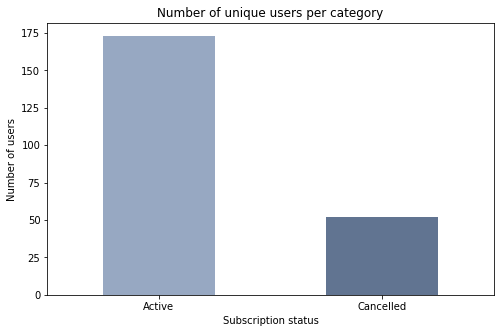

In [14]:
plotting_compare_users(['userId'], ['churn'], ['Active', 'Cancelled'], ['#97a8c2','#617491'])

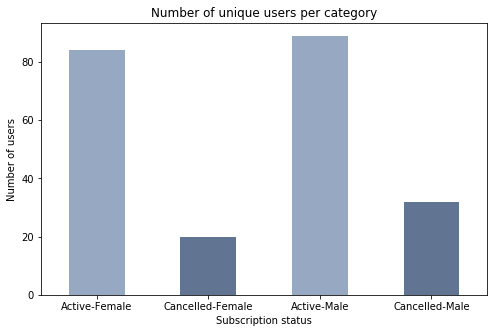

In [15]:
plotting_compare_users(['userId', 'gender'], 
                       ['gender', 'churn'], 
                       ['Active-Female', 'Cancelled-Female', 'Active-Male', 'Cancelled-Male'],
                       ['#97a8c2','#617491', '#97a8c2','#617491'])

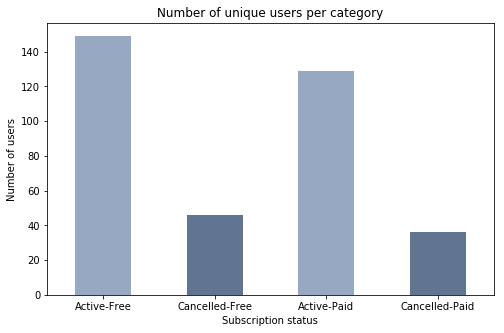

In [16]:
plotting_compare_users(['userId', 'level'], 
                       ['level', 'churn'], 
                       ['Active-Free', 'Cancelled-Free', 'Active-Paid', 'Cancelled-Paid'],
                       ['#97a8c2','#617491', '#97a8c2','#617491'])

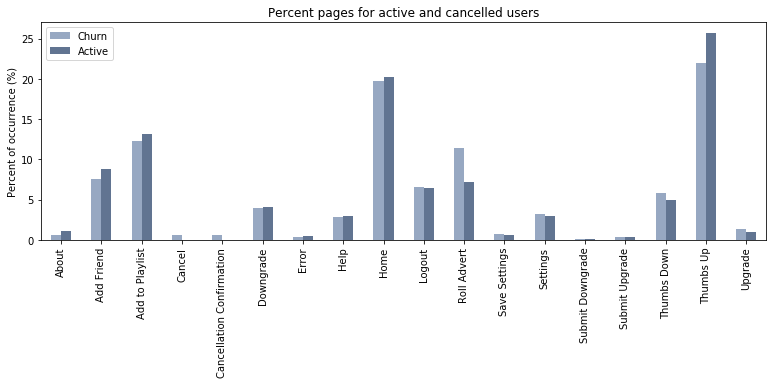

In [17]:
churn_users = pdf[pdf.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
churn_users = (churn_users /churn_users.sum()*100).sort_values(ascending=False)

active_users = pdf[pdf.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
active_users = (active_users /active_users.sum()*100).sort_values(ascending=False)

users_df = pd.DataFrame({'Churn': churn_users,'Active':active_users})
ax = users_df.plot(kind='bar', figsize=(13,4), color = ['#97a8c2','#617491']);
ax.set_ylabel('Percent of occurrence (%)')
ax.set_title('Percent pages for active and cancelled users');

In [18]:
active_users.sort_values(ascending=False)

page
Thumbs Up           25.716760
Home                20.228016
Add to Playlist     13.199923
Add Friend           8.757456
Roll Advert          7.133923
Logout               6.429190
Thumbs Down          4.930729
Downgrade            4.132192
Settings             2.992111
Help                 2.922359
About                1.055898
Upgrade              0.930825
Save Settings        0.606119
Error                0.529151
Submit Upgrade       0.305465
Submit Downgrade     0.129883
Name: userId, dtype: float64

### Time features

In [19]:
# Create functions to extract time features from ts

hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

# Adding columns to sdf
jobs = {'hour':hour, 'day':day, 'month':month, 'weekday':weekday}
for item, job in jobs.items():
    sdf = sdf.withColumn(item, job(sdf.ts))
    print(f'Column {item} added successfully.')

Column hour added successfully.
Column day added successfully.
Column month added successfully.
Column weekday added successfully.


In [20]:
pdf = sdf.toPandas()
pdf.sample(1)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,churn,hour,day,month,weekday
219412,Andres Calamaro,Logged In,Lauren,F,151,Boone,227.16036,paid,"St. Louis, MO-IL",PUT,...,No Va Mas,200,1539275060000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",300009,0,16,11,10,4


In [32]:
def group_by_col(col, churn, percent=False):
    ''' 
    INPUT
    col: str the column to plot (hour, month, day, week_day)
    churn: binary (0 or 1)
    percent: boolean (Default False)
    OUTPUT
    Returns a series of churn or active users.
    If percent = True, returns a percent value
    '''
    array = pdf[pdf.churn == churn].groupby([col])['userId'].count()
    try:
        array.index = array.index.astype(int)
    except:
        pass
    if percent:
        array=array/array.sum()*100
    return array.sort_index()

def draw_time(col, plot_style='bar', normalize=True, lab_angle=0, figsize=(16,4), title=None):
    '''
    Draw a bar plot for churn and existing users based on 
         a specific column (hour, month, day, week_day)
         
    normalize: {bool} T/F, Default is True
    figsize: {tuple} the plot size, default is (16,4)
    title: descriptive title part
    Returns: None
    '''
    by_time = pd.DataFrame({'Cancelled': group_by_col(col, 1, normalize),
                            'Active users':group_by_col(col, 0, normalize)})
    ax = by_time.plot(kind= plot_style, figsize=figsize, color=['#f0aaaa','#9daecf'], linewidth=4);
    
    try:
        title = col
        ax.set_title(f'Percent of users took action per {title}') 
    except:
        pass
    ax.set_ylabel(f'Activity of users(percentage)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=lab_angle)

    return ax

Although **there´s not enough months data** to extract valuable information, churn users were more active in October, whereas active users were more active during November. Maybe due to the closeness of Christmas and yearly renewal fees are coming? 

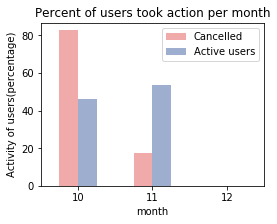

In [33]:
draw_time('month', 'bar', title='month', figsize=(4,3))

When looking at the **day of the month**, we observe:
- Active users interact regularly with the platform, no trends to remark.
- Churn users are much more active during the first days of the month, decreasing their activity when reaching the end of the month. This makes sense as renewal charges use to come with the last days of the month

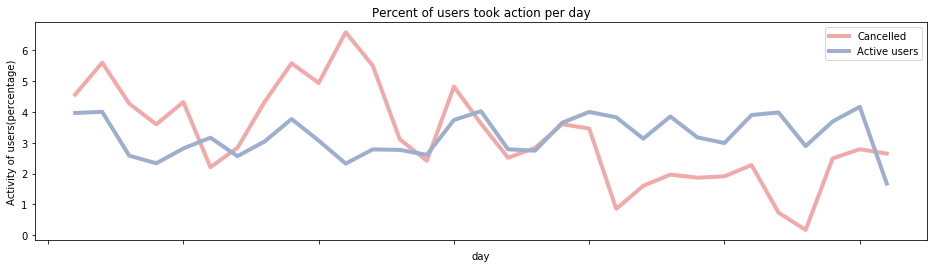

In [37]:
draw_time('day', 'line', title='day month');

**Activity by hour**

There is not a significative difference between active and churn users when looking at their behaviour in the platform by hour. Churn users seem to be more active between 15-20h, something that could have some inffluence in the prediction of our model

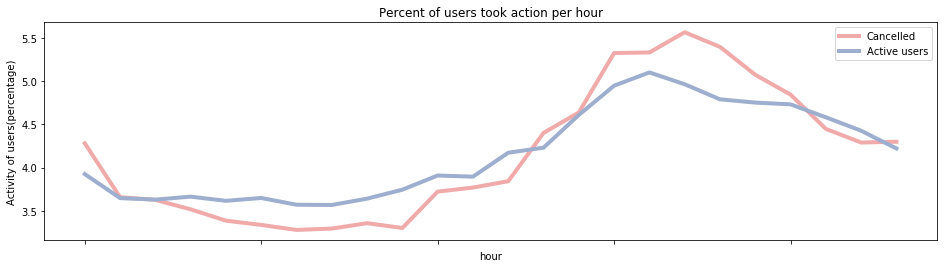

In [39]:
draw_time('hour', 'line', title='hour of the day');

When looking at the **activity by weekday**, we spot a decrease in the usage in Mondays and Sundays, but not huge difference between Churn and Active users. However, churn users use more the platform over active users on Mondays, whereas it happens the opposite on Fridays and Saturdays.

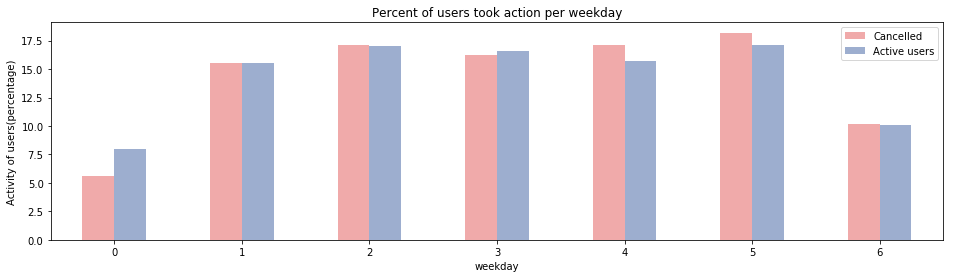

In [25]:
draw_time('weekday', 'bar', title='hour of the day');

## Categorical features

- **OS feature from userAgent** Regarding the analysis below, it seems that Mac users are more satisfied with the service, so they tend to be more active than free users. When digging deeper, it turns that Ipad and Iphone users are indeed quite happy with Sparkify paid account, but not Mac0S desktop. Possible questions are: is the UX better in Iphone and Ipad? Shall we redefine Windows user interface to improve their feeling with the service?

This an evidence of why we want to create new features, they can bring potential predictive power.


In [26]:
# Extract OS from userAgent
agents = [x.strip() for x  in pdf.userAgent.unique()] 
#Define regular expresion
reg_ = '\(([^\)]*)\)'

# Check unique values for OS system
unique_OS = list(set([re.findall(reg_, x)[0].split(';')[0].capitalize() for x  in agents]))
# Set mapping values to have just general OS, no versions
general_OS = ['MacOS', 'MacOS', 'Windows', 'Windows', 'Linux', 
              'Windows', 'Windows', 'Windows', 'Windows', 'MacOS']
version_OS = ['MacOS', 'Iphone', 'Windows 7 on', 'Windows XP', 'Linux', 
              'Windows 7 on', 'Windows 7 on', 'Windows 7 on', 'Compatible', 'Ipad']
# Create mapping dict
general_map_labels = {unique_OS[i]: general_OS[i] for i in range(len(unique_OS))} 
version_map_labels = {unique_OS[i]: version_OS[i] for i in range(len(unique_OS))} 
# Check
set([general_map_labels[re.findall(reg_, x)[0].split(';')[0].capitalize()] for x  in agents]), \
set([version_map_labels[re.findall(reg_, x)[0].split(';')[0].capitalize()] for x  in agents])

({'Linux', 'MacOS', 'Windows'},
 {'Compatible',
  'Ipad',
  'Iphone',
  'Linux',
  'MacOS',
  'Windows 7 on',
  'Windows XP'})

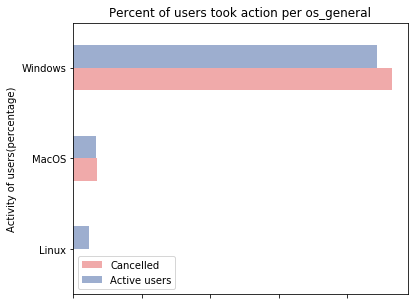

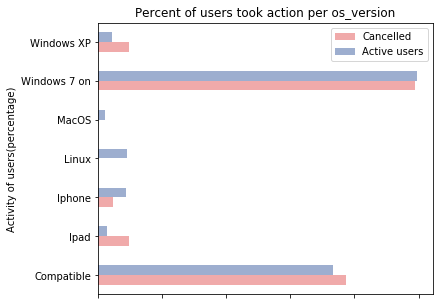

In [27]:
# Define user defined functions
os_general = udf(lambda x: general_map_labels[re.findall(reg_, x)[0].split(';')[0].capitalize()])
os_version = udf(lambda x: version_map_labels[re.findall(reg_, x)[0].split(';')[0].capitalize()])

# Add columns
sdf = sdf.withColumn("os_general", os_general(sdf.userAgent))
sdf = sdf.withColumn("os_version", os_version(sdf.userAgent))

# Turn to pandas for plotting
pdf = sdf.toPandas()

# Plot
draw_time('os_general', 'barh', lab_angle=65, figsize=(6,5)) 
draw_time('os_version', 'barh', lab_angle=65, figsize=(6,5))

- **Location**. Extract generalizable categorical info from 'location', as state. After plotting results it is easy to spot that states where users are based has a strong inffluence in whether they are active or churn users.

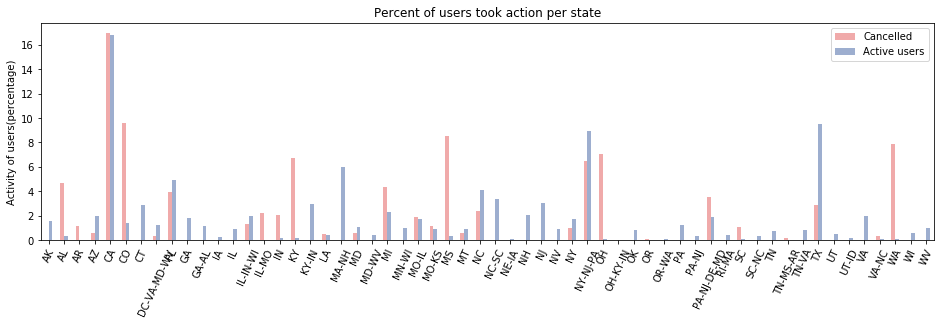

In [28]:
# Define a function to extract state from locatio feature
get_state = udf(lambda x: x.split(',')[1].strip())
sdf = sdf.withColumn("state", get_state(sdf.location))

# Turn to pandas for plotting
pdf = sdf.toPandas()
# Plot
draw_time('state', 'bar', title='hour of the day', lab_angle=65);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Features we want to keep:

**Numeric features**
- Num of ThumbsUp
- Num of ThumbsDown
- Num of InviteFriends
- Num of downgrades
- Num of songs per session
- ... basically counting appearances of **all possible values for the 'page' feature**

- Num of artists the user fans
- Session's duration
- Sessions' count per user
- Song length per user per session
- Percentage of paid/free songs a user has played

**Categoric features (needs to be converted to numeric form through dummi encoding**
- Gender of user
- The user's OS os_specific

In [29]:
churn_users = sdf.select('userId', 'churn').dropDuplicates()
# check
churn_users.show(4)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
+------+-----+
only showing top 4 rows



In [30]:
def create_dummy(col, map):
    '''
    INPUT
    col: col(feature) name
    map: dictionary mapping to integer values
    OUTPUT:
    - Create a Dataframe of 2 columns
    '''
    # First, map to string numbers. Otherwise spark would return an error
    # Convert then the column to numeric value
    col_df = sdf.select('userId', col).dropDuplicates().replace(map, subset=col) 
    col_df = col_df.select('userId', col_df[col].cast('int'))
    # Check value types
    print(col_df.printSchema())
#     print(col_df.show(3))
    return col_df


**Dummy variables from 'gender' and 'level'**  
Although we will not use level for the final_df, it will be used for engineering other feature below.

In [31]:
gender_df = create_dummy('gender', {'M':'1', 'F':'0'})
level_df = create_dummy('level', {'paid':'1', 'free':'0'})

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)

None
root
 |-- userId: string (nullable = true)
 |-- level: integer (nullable = true)

None


**Get Dummies from 'os_version', a categoric feature with multiple labels**

In [32]:
# Got solution from stackoverflow forum

os_names =  sdf.select('os_version').distinct().rdd.flatMap(lambda x: x).collect()
function = [sF.when(sF.col('os_version') == osdt, 1).otherwise(0).alias("OS_" + osdt) for osdt in os_names]
os_version_df = sdf.select('userId', *function)
os_version_df.show(2)

# Check value types
os_version_df.printSchema()

+------+---------------+--------+--------+---------+-------+-------------+-------------+
|userId|OS_Windows 7 on|OS_Linux|OS_MacOS|OS_Iphone|OS_Ipad|OS_Windows XP|OS_Compatible|
+------+---------------+--------+--------+---------+-------+-------------+-------------+
|    30|              1|       0|       0|        0|      0|            0|            0|
|     9|              1|       0|       0|        0|      0|            0|            0|
+------+---------------+--------+--------+---------+-------+-------------+-------------+
only showing top 2 rows

root
 |-- userId: string (nullable = true)
 |-- OS_Windows 7 on: integer (nullable = false)
 |-- OS_Linux: integer (nullable = false)
 |-- OS_MacOS: integer (nullable = false)
 |-- OS_Iphone: integer (nullable = false)
 |-- OS_Ipad: integer (nullable = false)
 |-- OS_Windows XP: integer (nullable = false)
 |-- OS_Compatible: integer (nullable = false)



**Number of sessions per user**. Just make a count of the number of sessions each user has opened.

In [33]:
num_session_df = sdf.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions')
num_session_df.show(3)

+------+------------+
|userId|num_sessions|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
+------+------------+
only showing top 3 rows



**Calculate Mean and Standard Deviation for each user´s:**
- Session duration 
- Song lengh
- Number of songs per session

Song lengh:

In [34]:
# Song lenght
song_length_df = sdf.filter(sdf.page=='NextSong').select('userId', 'sessionId', 'length')
song_length_df = song_length_df.withColumn('hours', (song_length_df.length / 3600))
song_length_df = song_length_df.groupBy('userId', 'sessionId').sum('hours')
song_length_df = song_length_df.groupBy('userId').agg(
                        sF.avg('sum(hours)').alias('mean_hours'), 
                        sF.stddev('sum(hours)').alias('stdev_hours')).na.fill(0)
song_length_df.toPandas().head(2)

,userId,mean_hours,stdev_hours
0,100010,2.656385,1.594089
1,200002,4.352263,3.481087


Session duration

In [35]:
# First, get Session Duration per each session for each user
start_session = sdf.groupBy('userId', 'sessionId').min('ts').withColumnRenamed(
                                                            'min(ts)', 'start')
finish_session = sdf.groupBy('userId', 'sessionId').max('ts').withColumnRenamed(
                                                            'max(ts)', 'end')
sessions_df = start_session.join(finish_session,['userId', 'sessionId'])
# seconds in an hour
seconds_hour = 1000 * 60 * 60
sessions_df = sessions_df.select('userId', 'sessionId', ((
    sessions_df.end-sessions_df.start)/seconds_hour).alias('session_hours'))
sessions_df.show(3)

# Calculate Average and Standard Deviation all session´s duration for each user
session_user_df = sessions_df.groupBy('userId').agg(
                        sF.avg('session_hours').alias('mean_session_h'), 
                        sF.stddev('session_hours').alias('stdev_session_h'))
# Fill NaN with 0
session_user_df = session_user_df.na.fill(0)
session_user_df.show(2)

+------+---------+------------------+
|userId|sessionId|     session_hours|
+------+---------+------------------+
|   101|      635|55.000277777777775|
|   110|     1776|1.3908333333333334|
|   120|      627|15.855555555555556|
+------+---------+------------------+
only showing top 3 rows

+------+-----------------+------------------+
|userId|   mean_session_h|   stdev_session_h|
+------+-----------------+------------------+
|100010|2.574722222222223|1.5888758093219746|
|200002|             4.44| 3.615756029749058|
+------+-----------------+------------------+
only showing top 2 rows



Number of songs per session

In [36]:
# number of changing songs
song_user_df = sdf.filter(sdf.page == 'NextSong').groupBy(
                        'userId', 'sessionId').count()
song_user_df = song_user_df.groupBy('userId').agg(
                        sF.avg('count').alias('mean_songs'), 
                        sF.stddev('count').alias('stdev_songs'))
song_user_df = song_user_df.na.fill(0)
song_user_df.show(3)

+------+------------------+------------------+
|userId|        mean_songs|       stdev_songs|
+------+------------------+------------------+
|100010|39.285714285714285| 22.96166577663945|
|200002|              64.5|51.309843110264914|
|   125|               8.0|               0.0|
+------+------------------+------------------+
only showing top 3 rows



**Data engineering for the 'page' feature:**

- We will count the frequency of each kind of page for each user, normalizing the values by calculating the percentage of each page in relation with the total of pages the user visited.
- Users visiting the pages 'Cancel' and 'Cancellation Confirmation' are users that have already cancelled his/her subscription, so in terms of our analysis, we already know such information (churn feature). Thus, we are rather interested in any of the other pages the were visiting before cancelling or remaining. We will get rid of those cancellation pages for the sake of the analysis and the model.

Normalizing each row to sum to 1
SOURCES
https://stackoverflow.com/questions/47641076/spark-normalize-each-row-of-a-dataframe
https://stackoverflow.com/questions/31955309/add-column-sum-as-new-column-in-pyspark-dataframe


In [37]:
sdf.dropDuplicates(['page']).select('page').show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [38]:
# Pages per user, dropping those pages directly related with churn.
user_page_df = sdf.groupby('userId').pivot('page').count().na.fill(0) #.toPandas().head(30)
user_page_df = user_page_df.drop(*['Cancel','Cancellation Confirmation'])

# The columns we want to sum are all remaining in the df except UserId:
# Calculate total pages per user and add to the df
cols_to_sum = user_page_df.columns[1:]
df_new = user_page_df.withColumn('total', sum(user_page_df[col] for col in cols_to_sum))
# Apply normalization per column
for col in cols_to_sum:
    df_new = df_new.withColumn(f'norm_{col}', df_new[col] / df_new['total'] * 100.)
    
# Drop original columns + total column (we´ve already used it to nomalizethe new ones)
df_new = df_new.drop('total') 
df_new = df_new.drop(*cols_to_sum)
# reset column names
colnames = df_new.columns
new_colnames = ['userId'] + cols_to_sum
user_page_df = reduce(lambda df_new, idx: df_new.withColumnRenamed(colnames[idx], new_colnames[idx]), range(len(colnames)), df_new)

user_page_df.toPandas().head(10)

,userId,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,0.632911,0.843882,1.687764,1.054852,0.000000,0.421941,4.219409,1.054852,81.645570,1.476793,0.000000,0.632911,0.000000,0.210970,1.265823,4.430380,0.421941
1,100010,0.262467,1.049869,1.837270,0.000000,0.000000,0.524934,2.887139,1.312336,72.178478,13.648294,0.000000,0.000000,0.000000,0.000000,1.312336,4.461942,0.524934
2,125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.888889,11.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,51,0.081235,1.137287,2.112104,0.934200,0.040617,0.487409,3.046304,0.974817,85.743298,0.000000,0.040617,0.487409,0.000000,0.000000,0.852965,4.061738,0.000000
4,124,0.145078,1.533679,2.445596,0.849741,0.124352,0.476684,3.647668,1.222798,84.538860,0.082902,0.124352,0.414508,0.000000,0.000000,0.849741,3.544041,0.000000
5,7,0.000000,0.497512,2.487562,0.000000,0.497512,0.497512,4.975124,1.492537,74.626866,7.960199,0.497512,1.492537,0.000000,0.000000,0.497512,3.482587,0.995025
6,54,0.145560,0.960699,2.096070,1.135371,0.029112,0.494905,3.755459,1.048035,82.707424,1.368268,0.087336,0.494905,0.029112,0.029112,0.844250,4.745269,0.029112
7,15,0.087796,1.360843,2.589991,1.229148,0.087796,0.351185,4.082529,1.185250,84.021071,0.043898,0.087796,0.702371,0.000000,0.000000,0.614574,3.555751,0.000000
8,155,0.199601,1.097804,2.395210,1.197605,0.299401,0.898204,2.994012,1.397206,81.836327,0.798403,0.000000,0.499002,0.000000,0.099800,0.299401,5.788423,0.199601
9,132,0.173611,1.779514,1.649306,0.824653,0.130208,0.694444,3.602431,1.475694,83.680556,0.086806,0.173611,0.737847,0.000000,0.043403,0.737847,4.166667,0.043403


**Number of artists each user consumes**

In [39]:
# Number of artists the user fans
artists_user_fans_df = sdf.select('userId', 'artist').dropDuplicates().groupBy('userId').count().withColumnRenamed("count", "num_aritst")
artists_user_fans_df.show(2)

+------+----------+
|userId|num_aritst|
+------+----------+
|100010|       253|
|200002|       340|
+------+----------+
only showing top 2 rows



**Free and paid histoy of each user**

Instead of calculating the time a user has been paid or free user, we´ll calculate the proportion of free and paid songs each user has listened. We´ll then drop one of the percentages becuse including both does not make any sense are they are 100% correlated.

In [40]:
hist_free_pay_df = sdf.filter(sdf.page=='NextSong').groupBy('userId').pivot('level').count()
hist_free_pay_df = hist_free_pay_df.na.fill(0)
hist_cols = hist_free_pay_df.columns[1:]
hist_free_pay_df = hist_free_pay_df.withColumn('total', 
                                       sum(hist_free_pay_df[col] for col in hist_cols))
for col in hist_cols:
    hist_free_pay_df = hist_free_pay_df.withColumn(f'{col}_percent', 
                                           hist_free_pay_df[col] / hist_free_pay_df.total * 100)
hist_cols.append('total')    
hist_free_pay_df = hist_free_pay_df.drop(*hist_cols)
# Drop one of the columns 
hist_free_pay_df = hist_free_pay_df.drop('free_percent')
hist_free_pay_df.show(3)

+------+-----------------+
|userId|     paid_percent|
+------+-----------------+
|200002|77.51937984496125|
|100010|              0.0|
|   125|              0.0|
+------+-----------------+
only showing top 3 rows



### All together
Join all the dfs we´ve been creating along the feature engineegring process to get it ready for MLearning modelling.
1. Create an initial df with UserId and the churn feature, which is the target feature we´ll be predicting when modelling.
2. Join each of the dfs we´ve created above, using UserId as key.

In [86]:
# Define a base df with userId and churn feature
# We´ll then be adding all the dfs developed above
all_df = sdf.select('userId', 'churn').dropDuplicates()
all_df.show(2)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
+------+-----+
only showing top 2 rows



In [87]:
# the features to collect and add to all_df. We´re excluding "level_df" as we´ve already used it to 
# engineer the paid and free songs features.
feat_add_dfs = [gender_df, os_version_df, num_session_df, 
                 song_length_df, session_user_df, song_user_df, user_page_df, 
                 user_page_df, artists_user_fans_df, hist_free_pay_df]

feat_add_names = ['gender_df', 'os_version_df', 'num_session_df', 
                 'song_length_df', 'session_user_df', 'song_user_df', 'user_page_df', 
                 'user_page_df', 'artists_user_fans_df', 'hist_free_pay_df']

In [88]:
import time 

def join_dfs(old_df, df_to_add): 
    new_df = old_df.join(df_to_add, 'userId', how='inner')
    return new_df.dropDuplicates()

total_start = time.time()
for i, df in enumerate(feat_add_dfs):
    start = time.time()
    print(f'Adding columns from {feat_add_names[i]} df', end='; ')
    all_df = join_dfs(all_df, df)
    time_diff = time.time() - start
    print (f"Done in {time_diff*100} secs. New df´s dimensions are: {all_df.count()} * {len(all_df.columns)}")

total_timediff = time.time() - total_start 

sp_all_df = all_df.orderBy('userId', ascending=True)
print(f'All features added to DataFrame, done in {total_timediff*100}')

Adding columns from gender_df df; Done in 3.0477523803710938 secs. New df´s dimensions are: 225 * 3
Adding columns from os_version_df df; Done in 5.285120010375977 secs. New df´s dimensions are: 225 * 10
Adding columns from num_session_df df; Done in 4.195070266723633 secs. New df´s dimensions are: 225 * 11
Adding columns from song_length_df df; Done in 5.698060989379883 secs. New df´s dimensions are: 225 * 13
Adding columns from session_user_df df; Done in 9.384918212890625 secs. New df´s dimensions are: 225 * 15
Adding columns from song_user_df df; Done in 6.154990196228027 secs. New df´s dimensions are: 225 * 17
Adding columns from user_page_df df; Done in 3.025221824645996 secs. New df´s dimensions are: 225 * 34
Adding columns from user_page_df df; Done in 29.464292526245117 secs. New df´s dimensions are: 225 * 51
Adding columns from artists_user_fans_df df; Done in 7.073855400085449 secs. New df´s dimensions are: 225 * 52
Adding columns from hist_free_pay_df df; Done in 8.73231887

In [103]:
# remove all empty spaces in column names
new_col_names = []
for name in col_names:
    new_col_names.append(name.replace(' ', '_')) 
pd_all_df.columns = new_col_names
pd_all_df.head(1)

,userId,churn,gender,OS_Windows_7_on,OS_Linux,OS_MacOS,OS_Iphone,OS_Ipad,OS_Windows_XP,OS_Compatible,...,Roll_Advert,Save_Settings,Settings,Submit_Downgrade,Submit_Upgrade,Thumbs_Down,Thumbs_Up,Upgrade,num_aritst,paid_percent
0,10,0,1,0,0,0,0,0,0,1,...,0.125786,0.125786,0.880503,0.0,0.0,0.503145,4.654088,0.0,566,100.0


In [104]:
# Save df to a csv file
pd_all_df.to_csv('Sparkify_MLReady_Users2.CSV', index=False)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [45]:
final_df = spark.read.csv('Sparkify_MLReady_Users2.CSV', header = True)
pd_final_df = final_df.toPandas()

final_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- OS_Windows_7_on: string (nullable = true)
 |-- OS_Linux: string (nullable = true)
 |-- OS_MacOS: string (nullable = true)
 |-- OS_Iphone: string (nullable = true)
 |-- OS_Ipad: string (nullable = true)
 |-- OS_Windows_XP: string (nullable = true)
 |-- OS_Compatible: string (nullable = true)
 |-- num_sessions: string (nullable = true)
 |-- mean_hours: string (nullable = true)
 |-- stdev_hours: string (nullable = true)
 |-- mean_session_h: string (nullable = true)
 |-- stdev_session_h: string (nullable = true)
 |-- mean_songs: string (nullable = true)
 |-- stdev_songs: string (nullable = true)
 |-- About17: string (nullable = true)
 |-- Add_Friend18: string (nullable = true)
 |-- Add_to_Playlist19: string (nullable = true)
 |-- Downgrade20: string (nullable = true)
 |-- Error21: string (nullable = true)
 |-- Help22: string (nullable = true)
 |-- Home23: string (nulla

### We need to perform some changes to get the model ready for ML
1. Fill nulls with zeros fo the whole dataset
2. Convert feature´s data types to integers and floats, as they are considered as strings by default

In [46]:
# Replace nans with zeros in the whole dataset
final_df = final_df.na.fill(0)

# All columns to OS_Compatible will be converted to integers
for col in final_df.columns[:10]:
    final_df = final_df.withColumn(col, final_df[col].cast(sT.IntegerType()))
# Rest of the df will be treated as floats
for col in final_df.columns[10:]:
    final_df = final_df.withColumn(col, final_df[col].cast(sT.FloatType()))

# Check columns data types
final_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- OS_Windows_7_on: integer (nullable = true)
 |-- OS_Linux: integer (nullable = true)
 |-- OS_MacOS: integer (nullable = true)
 |-- OS_Iphone: integer (nullable = true)
 |-- OS_Ipad: integer (nullable = true)
 |-- OS_Windows_XP: integer (nullable = true)
 |-- OS_Compatible: integer (nullable = true)
 |-- num_sessions: float (nullable = true)
 |-- mean_hours: float (nullable = true)
 |-- stdev_hours: float (nullable = true)
 |-- mean_session_h: float (nullable = true)
 |-- stdev_session_h: float (nullable = true)
 |-- mean_songs: float (nullable = true)
 |-- stdev_songs: float (nullable = true)
 |-- About17: float (nullable = true)
 |-- Add_Friend18: float (nullable = true)
 |-- Add_to_Playlist19: float (nullable = true)
 |-- Downgrade20: float (nullable = true)
 |-- Error21: float (nullable = true)
 |-- Help22: float (nullable = true)
 |-- Home23: float (nullable 

### ... and more

3. Create vectorassembler object and transform the data with it
4. Scale data with StandardScaler (in this case, we could have used others)
5. Select 'label' feature and create the 'features' column incuding all input features.
6. Split datset into training and testing

In [47]:
# Create vectorAssembler for input feats
features_vector = VectorAssembler(inputCols=final_df.columns[2:], outputCol='features')
# Apply to dataset
data = features_vector.transform(final_df)

# Scale dataset using StandardScaler (we could have used other, even add it to grid)
scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='features_scaled')
# Use it to FIT and TRANSFORM dataset
scaler_fit = scaler.fit(data)
scaled_data = scaler_fit.transform(data)

# Select the output and input features
model_data = scaled_data.select(scaled_data.churn.alias('label'), scaled_data.features_scaled.alias('features'))

# check
model_data.show(2)

# Defining training and testing samples
train, test = model_data.randomSplit([0.80, 0.20], seed=164)

# Check
train.show(2), test.show(2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.92503195288915...|
|    0|[0.92503195288915...|
+-----+--------------------+
only showing top 2 rows

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-1.0762390990345...|
|    0|[-1.0762390990345...|
+-----+--------------------+
only showing top 2 rows

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-1.0762390990345...|
|    0|[-1.0762390990345...|
+-----+--------------------+
only showing top 2 rows



(None, None)

### Functions
We´ll define some functions to make the code modular and the modelling process easier to understand:
1. string_time --> Function to convert time difference into a string  easy to understand.
2. model_fitting --> Function to fit a given model to a dataset, with some adittional inputable arguments
3. get_metrics --> Function to predict and measure performance of a model based on accuracy and F1 Score.

In [48]:
# Define a function to convert time difference in a readable format with the goal
# of measuring the time spent to train each model
def string_time(t_dif):
    minutes = 0
    if t_dif > 60 :
        minutes = round(t_dif / 60)
        secs = t_dif - (minutes * 60) 
    else:
        secs = t_dif
    stamp = '{} minutes and {} seconds'.format(minutes, secs)
    return stamp



# Define a function to train a model with a given dataset, including 
# crossvalidation and tuning hyperparameters using grid
def model_fitting(df, model_to_use, param_grid, save_path, folds = 3, random_seed = 164):
    '''
    INPUT
    df : data to fit the model with
    model_to_use : model to fit
    param_grid : object defining different hyperparameters to tune the model
    save_path : name to save the model with
    folds : number of folds for cross validation 
    random_seed : seed for the random selection in the cross validation
    OUTPUT
    
    '''
    model_evaluator = CrossValidator(estimator = model_to_use, estimatorParamMaps = param_grid,
                                      evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                                      numFolds = folds, seed = random_seed)
    t_start = time.time()
    print ('Fitting model {}'.format(model_to_use))
    model_fit = model_evaluator.fit(df)
    diff_time = time.time() - t_start
    print ('Model fitted in {}'.format(string_time(diff_time)))
    t_start = time.time()
    print ('Save model as {}...'.format(save_path))
    # Try to save, if it already exists, we have to define the error exception as it will give an error
    try:
        model_fit.save(save_path)
        print ('Creating the model file', end='')
    except:
        model_fit.write().overwrite().save(save_path)
        print ('Overwriting existing model with same name', end='')
    diff_time = time.time() - t_start
    print ('Finished in {}'.format(string_time(diff_time)))
    return model_fit



# Define a Function to predict based on test or train, 
# and get accuracy and f1_score metrics for the given model
def get_metrics(model, data, name):
    '''
    INPUT
    model : trained model we want to measure performance
    data : train or test set calculate metrics
    OUTPUT
    This function does not return any output, it just prints 
    the name of the model followed by the accuracy and f1_score
    '''
    results = model.transform(data)
    
    evaluator_accuracy = MulticlassClassificationEvaluator(metricName='accuracy')
    accuracy = evaluator_accuracy.evaluate(results.select('label', 'prediction'))
    evaluator_f1_score = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = evaluator_f1_score.evaluate(results.select('label', 'prediction'))
    
    print('For {}, the accuracy on the {} set is {:.2%} and the F-1 score is {:.2%}'\
    .format(name_to_save, name, accuracy, f1_score))

### Random Forest Classifier
Hyperparameters defined in our GridSearchCV:  
- **minInfoGain**: Minimum amount of information gained about a variable when performing a split within a decision tree. Do not make the split if we´re not going to adquire less info than minInfoGain value.
- **numTrees**: Number of trees to be created within the forest ensemble. 
- **maxDepth**: maximum number of splitting levels to structure the data each tree from the GBT ensemble can go. Important to limit it for preventing the model from learn the data and not the trends from it, the so called overfitting.

In [69]:
model = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.minInfoGain, [0, 1]) \
    .addGrid(model.numTrees, [20, 50]) \
    .addGrid(model.maxDepth, [5, 10]) \
    .build()

name_to_save = 'Random Forest'

model = model_fitting(train, model, param_grid, name_to_save, folds = 5)
get_metrics(model, train, 'train')
get_metrics(model, test, 'test')

Fitting model RandomForestClassifier_9bcb5da61844
Model fitted in 0 minutes and 39.724337339401245 seconds
Save model as Random Forest...
Overwriting existing model with same nameFinished in 0 minutes and 0.7511279582977295 seconds
For Random Forest, the accuracy on the train set is 100.00% and the F-1 score is 100.00%
For Random Forest, the accuracy on the test set is 72.50% and the F-1 score is 63.04%


### Logistic Regression

Hyperparameters defined in our GridSearchCV: 

Regularization parameters, to try the model between L1 and L2:
- **elasticNetParam** (alpha): The elastic net penalty is defined to set a point in between a Lasso model (elasticparam=1, removing degeneracies caused by hard correlations) and a Ridge method (elasticParam=0, shrinking coefficients of correlated variables). For alpha = 0.0, the penalty is an L2 penalty. For alpha = 1.0, it is an L1 penalty. For 0.0 < alpha < 1.0, the penalty is a combination of L1 and L2. Default is 0.0 which is an L2 penalty
- **regParam** (lambda):  regularization parameter, used to add additional information to fix ill-posed problems.

Other:
- **aggregationDepth**: Depth for tree Aggregations performed by Spark when performing training. If feature´s dimensions or number of partitions are large, this param could be set larger.


In [70]:
model = LogisticRegression()
param_grid = ParamGridBuilder() \
    .addGrid(model.regParam,[0.01, 0.1]) \
    .addGrid(model.elasticNetParam,[0.0, 0.5]) \
    .addGrid(model.aggregationDepth,[2, 5]) \
    .build()
name_to_save = 'Logistic Regression'

model = model_fitting(train, model, param_grid, name_to_save, folds = 5)

get_metrics(model, train, 'train')
get_metrics(model, test, 'test')

Fitting model LogisticRegression_b7bb95456569
Model fitted in 1 minutes and 23.419886827468872 seconds
Save model as Logistic Regression...
Overwriting existing model with same nameFinished in 0 minutes and 0.5853111743927002 seconds
For Logistic Regression, the accuracy on the train set is 80.54% and the F-1 score is 76.06%
For Logistic Regression, the accuracy on the test set is 77.50% and the F-1 score is 74.62%


### Gradient Boosting Tree 

Hyperparameters defined in our GridSearchCV: 
- **maxDepth**: maximum number of splitting levels to structure the data each tree from the GBT ensemble can go. It is crucial to limit it in order to prevent overfitting. Otherwise the model would learn the data and not the trends from it, which is the goal.
- **maxBins**: maximum numbers of "bags" where the trees store values in each split. If it splits info contained within a bin in level 0, the maximum number of bins to divide that info is defined with maxBins.
- **maxIter**: Maximum number of iterations, in this case number of trees in the GBT ensemble

In [11]:
model = GBTClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[4,10]) \
    .addGrid(model.maxBins ,[15, 20]) \
    .addGrid(model.maxIter ,[20, 30]) \
    .build()

name_to_save = 'Gradient Boosting Class'

model = model_fitting(train, model, param_grid, name_to_save, folds = 5)

get_metrics(model, train, 'train')
get_metrics(model, test, 'test')

Fitting model GBTClassifier_72f47db1fde5
Model fitted in 10 minutes and -6.184101819992065 seconds
Save model as Gradient Boosting Class...
Overwriting existing model with same nameFinished in 0 minutes and 3.705993413925171 seconds
For Gradient Boosting Class, the accuracy on the train set is 100.00% and the F-1 score is 100.00%
For Gradient Boosting Class, the accuracy on the test set is 80.00% and the F-1 score is 76.62%


# Model analysis

For the present analysis, it is crucial to take into account that just tracking accuracy can be misleading for two main reasons:
- The **small size** of the ML Ready Dataset (just around 250 users)
- The **imbalance between classes**
So we have been keeping track of F1 Score along with accuracy for the three models tried:

**After training ang tuning these 3 different classifiers**, results show:
- **Random forest** performs simply perfect (Accuracy 100%) with training set but significantly worse with test (Accuracy 72,5%), showing a clear case of overfitting, typical in Random Forests when not setting a limit for depth. It could be improved working harder in the grid hyperparameters tuning
- **Logistic Regression** performs smoothly and quite similarly both in train (80.54% Acc) and test (77,5% Acc), with a nice F1 Score results(76% train, 74% test), assuring us a good balance between Precision and Recall. Nice efficiency while training, making it a nice candidate to be the chosen one.
- **GBT** although its results (both accuracy and F1 Score) for the test set are even better than Logistic Regression, it shows symptoms of overfitting as it is essentially a boosted random forest. Again it could be fixed by working in hyperpameter tuning and extending the number of folds in Cross Validation. The fitting time is a bit longer than the other two, though.

## Selected model
**Logistic Regression** seems to be the best candidate for the present job, so we should dig deeper to understand it´s performance:

### Model parameters
We performed a GridSearch trying different combinations of hyperparameters with the goal of achieving the best possible model. It is interesting to look at those parameters for the resulting "bestModel" within all the Logistic Regressions tried.

In [96]:
best = model.bestModel
param_names_raw = best.extractParamMap().keys()
param_names_clean = []
for param in param_names:
    param_names_clean.append(str(param).split('__')[1]) 
    
param_values = list(best.extractParamMap().values())

params_df = pd.DataFrame(param_values,index=param_names_clean, columns = ['value'])

print(f'After gridsearch, the parameters we optimized resulted in a bestModel with:')
print('- regParam = {}'.format(params_df.loc['regParam'][0]))
print('- elasticNetParam = {}'.format(params_df.loc['elasticNetParam'][0]))
print('- aggregationDepth = {}. It was the default value recommended by Spark'.format(params_df.loc['aggregationDepth'][0]))
print('Both regularization parameters ended up with a solution in betwwen L1 an L2')
print('\n')
print('Find below a df with resulting values for all hyperparameters ')
print('for the Logistic Regresion bestModel obtained after Grid Search:')

params_df

After gridsearch, the parameters we optimized resulted in a bestModel with:
- regParam = 0.01
- elasticNetParam = 0.5
- aggregationDepth = 2. It was the default value recommended by Spark
Both regularization parameters ended up with a solution in betwwen L1 an L2


Find below a df with resulting values for all hyperparameters 
for the Logistic Regresion bestModel obtained after Grid Search:


,value
family,auto
featuresCol,features
fitIntercept,True
labelCol,label
maxIter,100
predictionCol,prediction
probabilityCol,probability
rawPredictionCol,rawPrediction
standardization,True
threshold,0.5


### Feature importance

When training and predicting with a classifier, it is often important to give a clear explanation of what is going on within the "black box". MLearning is not a matter of faith but of math and common sense, so being able to explain the inffluence of each of the features to the prediction is crucial when explaining what the model is doing and what data is more important for the sake of the prediction.

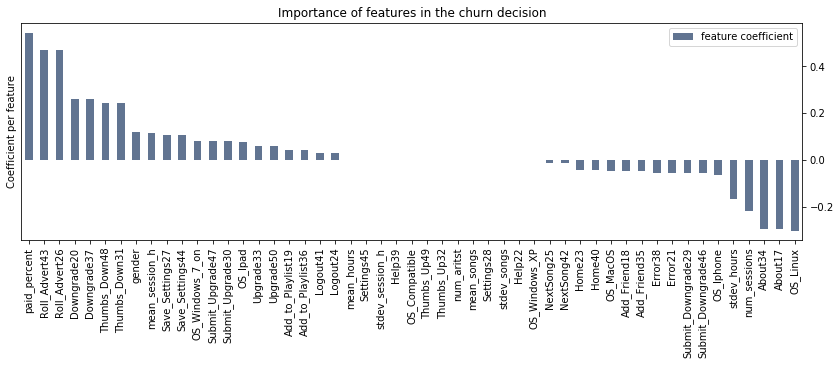

In [49]:
# Store feature names in an array
feat_names = final_df.columns[2:]
# Load selected model(LogReg) and extract feature coefficients
model = mlm.load('Logistic Regression')
feat_coeff = list(model.bestModel.coefficientMatrix.toArray()[0])
# Create a df with coeffieicnets an thei correspondant feature name
df = pd.DataFrame(feat_coeff, columns = ['feature coefficient'], index = feat_names) \
                .sort_values(by = 'feature coefficient', ascending = False)

# Plot feature importance for the selected model
ax = df.plot(kind='bar', figsize=(14,4), color = ['#617491']);
ax.set_ylabel('Coefficient per feature')
ax.set_title('Importance of features in the churn decision');
ax.yaxis.tick_right()

As shown in the chart above, there are:
- Several **features with almost no inffluence in the churn decision** as ThumbsUp, number of songs and artists, length of session, or some pages (Help, Settings). 
- Some **features directly related with churning**, as Percentage of paid songs, Roll Advert, Downgrade, Thumbs Down, or OS as Windows or Ipad, meaning that if a user shows this behavioural or static information is more prone to churn. 
- In addition there are several **inversely related features with the churn decision** as OS Linux, MacOS and Iphone, number of sessions, adding friends or visiting Home page. Users showing this info are prone to remain as paid users.


### Improving the selected model
It seems that Logistic Regression is the best candidate for the present job, so we could refine even more its performance:
- Expanding the size of our dataset with information of more users, helping the model to generalize to new data as it would be learning from a much bigger sample of a population. The present mini subset is quite limited in this terms. However we can use the same code to perform Machine Learning Classification with the whole dataset (12GB) as it´s been written in Spark for Big Data situations.
- Getting deeper in feature engineering to develop new features (based on the information we already have) that can potentially have predictive power and improve the performance of the model, in this case the Logistic Regression Classifier. Some of the features we should start with are the ones related to location, as 'state', a feature we have excluded from the final_df but regarding the chart showed in the data exploration part, could have relevant influence in our predictive job.
- Trying more combinations of hyperparameters, including trying more folds in Cross Validation.

### Improvements in production

- For a company depending on monthly paying users, leveraging a model of this characteristics is crucial, as they can address users with a risk of being cancelling their suscriptions with around 80% of accuracy. The obvious error addressing False Positive Users should not be relevant, as they will likely be grateful with the company after receiving discounts or offers. Other action to tke could be improving interfaces and apps or even decreasing price for the OS where users seem to be less satisfied with the service (Windows in our analysis, specially with old versions).

- It is important to retrain the model to avoid making decisions based on outdated data. Specially in the changing world we live, users behaviours change fast and unpredictably. The only way is keeping track of their behavioural data to make decisions based on the most updated data we can get.


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.